In [1]:
# Install Gradio if not installed
!pip install gradio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.9 MB/s eta 0:00:00


In [2]:

# Load dataset
df = pd.read_csv('Maternal Health Risk Data Set.csv')

In [3]:
df.duplicated().sum()

np.int64(562)

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
# Encode RiskLevel as integers
risk_mapping = {"low risk": 0, "mid risk": 1, "high risk": 2}
df['RiskLevel'] = df['RiskLevel'].map(risk_mapping).astype(int)

<ipython-input-6-67a4bf3cd396>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['RiskLevel'], palette='coolwarm')


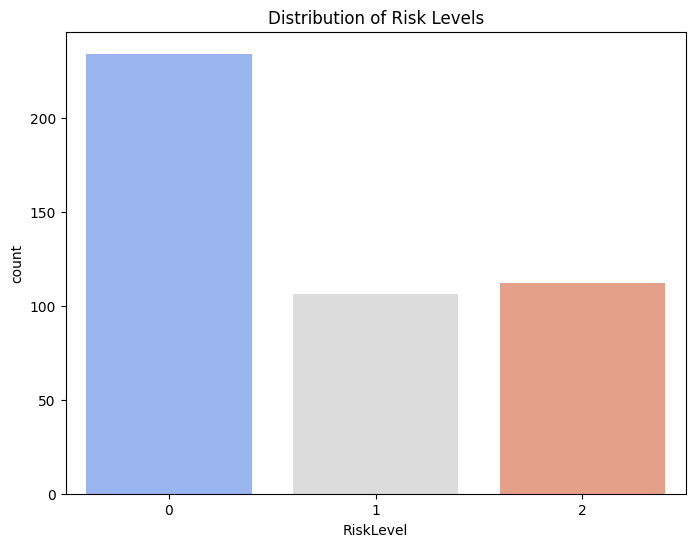

Inference: The dataset is imbalanced, requiring resampling techniques like SMOTE.


In [6]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8, 6))
sns.countplot(x=df['RiskLevel'], palette='coolwarm')
plt.title('Distribution of Risk Levels')
plt.show()
print("Inference: The dataset is imbalanced, requiring resampling techniques like SMOTE.")

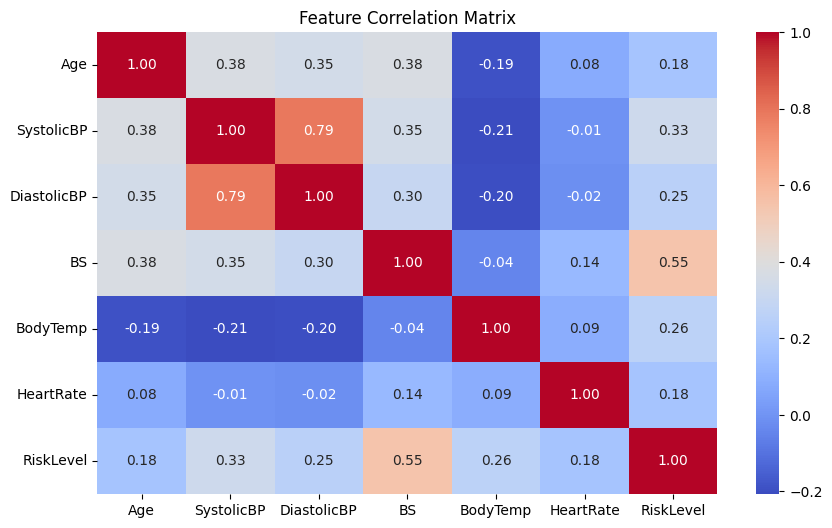

Key Inferences from Correlation Matrix:

Strongest Predictors of RiskLevel:
Blood Sugar (BS) (0.55)
SystolicBP (0.33) & DiastolicBP (0.25)

High Inter-Feature Correlation:
SystolicBP & DiastolicBP (0.79) move together.

Age Impact:
Moderately linked to BP (0.38, 0.42) and BS (0.38) but weakly to RiskLevel (0.27).

Weak/Negligible Links:
HeartRate shows near-zero correlation with other features.
BodyTemp has minor ties to risk (-0.21 to 0.26).


In [7]:
# Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()
print("""Key Inferences from Correlation Matrix:

Strongest Predictors of RiskLevel:
Blood Sugar (BS) (0.55)
SystolicBP (0.33) & DiastolicBP (0.25)

High Inter-Feature Correlation:
SystolicBP & DiastolicBP (0.79) move together.

Age Impact:
Moderately linked to BP (0.38, 0.42) and BS (0.38) but weakly to RiskLevel (0.27).

Weak/Negligible Links:
HeartRate shows near-zero correlation with other features.
BodyTemp has minor ties to risk (-0.21 to 0.26).""")

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Define features and target variable
X = df.drop(columns='RiskLevel')
y = df['RiskLevel']

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)  # Fit only on training data

# Get the best model
best_rf = grid_search.best_estimator_

# Evaluate on test data
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


y_pred = best_rf.predict(X)

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')
conf_matrix = confusion_matrix(y, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7898
Precision: 0.7892
Recall: 0.7898
F1 Score: 0.7644


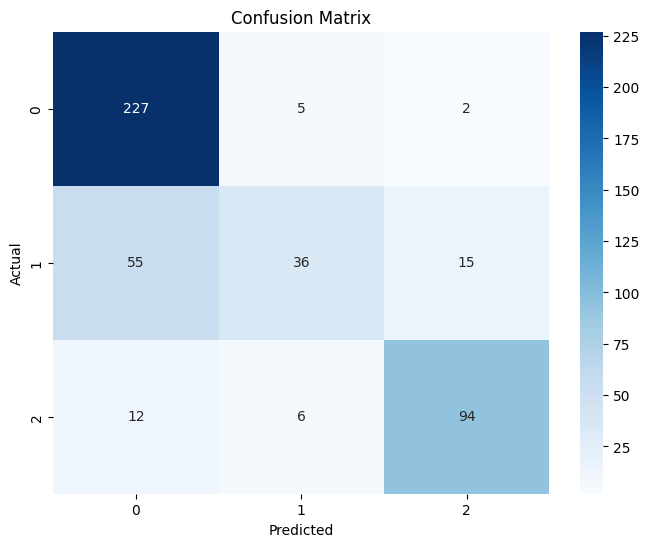

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [11]:
import gradio as gr
import pandas as pd
import numpy as np

# Define prediction function
def predict_risk(Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate):
    # Create a DataFrame from the input values
    input_data = pd.DataFrame({
        'Age': [Age],
        'SystolicBP': [SystolicBP],
        'DiastolicBP': [DiastolicBP],
        'BS': [BS],
        'BodyTemp': [BodyTemp],
        'HeartRate': [HeartRate]
    })

    # Ensure 'best_rf' is defined and trained before using it
    prediction = best_rf.predict(input_data)[0]

    # Map the prediction back to the risk level string
    risk_levels = {0: "low risk", 1: "mid risk", 2: "high risk"}
    predicted_risk = risk_levels[prediction]

    return predicted_risk

# Define Gradio interface
iface = gr.Interface(
    fn=predict_risk,
    inputs=[
        gr.Number(label="Age"),
        gr.Number(label="SystolicBP"),
        gr.Number(label="DiastolicBP"),
        gr.Number(label="BS"),
        gr.Number(label="BodyTemp"),
        gr.Number(label="HeartRate")
    ],
    outputs=gr.Textbox(label="Predicted Risk Level"),  # ✅ Added missing comma here
    title="Maternal Health Risk Prediction",
    description="Enter patient data to predict the risk level."
)

# Launch the interface
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1cae5f1d7818d30a99.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
